In [1]:
import sqlite3
import shapely
import pandas as pd
import geopandas as gpd

# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

i = 525

rivers = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/msc_rivers.feather")
rivers_subset = gpd.clip(rivers, grid_data.to_crs(4326).geometry.iloc[i])

In [6]:
import ctypes
import numpy as np

# Load the shared library
lib = ctypes.CDLL('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/analysis/deforestation_extract.so')

# Define the argument and return types for the function
lib.calculatePolygons.argtypes = [
    ctypes.POINTER(ctypes.c_double), 
    ctypes.POINTER(ctypes.c_double), 
    ctypes.c_int, 
    ctypes.c_double, 
    ctypes.POINTER(ctypes.POINTER(ctypes.c_double)), 
    ctypes.POINTER(ctypes.POINTER(ctypes.c_double))
]
lib.calculatePolygons.restype = None

# Define the input data
X, Y = np.array(rivers_subset.geometry.iloc[2].coords.xy, dtype = np.double)
distance = .005
N = len(X)

# Call the C++ function
polygonsX_ptr = ctypes.POINTER(ctypes.c_double)()
polygonsY_ptr = ctypes.POINTER(ctypes.c_double)()
lib.calculatePolygons(
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), 
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), 
    N, 
    distance, 
    ctypes.byref(polygonsX_ptr), 
    ctypes.byref(polygonsY_ptr)
)

# Convert the output to numpy arrays
polygonsX = np.ctypeslib.as_array(polygonsX_ptr, shape=(N - 3, 6))
polygonsY = np.ctypeslib.as_array(polygonsY_ptr, shape=(N - 3, 6))

test = np.array([shapely.geometry.Polygon([(polygonsX[i][j], polygonsY[i][j]) for j in range(6)]) for i in range(N - 3)])

# Free the allocated memory
lib.free(polygonsX_ptr)
lib.free(polygonsY_ptr)

0

In [7]:
test_series = gpd.GeoSeries(test).reset_index()

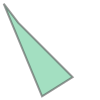

In [88]:
test_series.geometry.iloc[-4]

<Axes: >

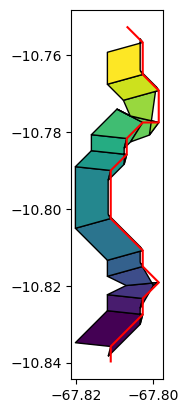

In [8]:
ax = rivers_subset.iloc[[2]].plot(color = "red")
test_series.plot(ax = ax, edgecolor = "black", column = "index")

In [36]:
test

array([[[-63.54319971, -12.60357447],
        [-67.81096781, -10.8358065 ],
        [-72.07873591,  -9.06803854],
        [-72.07040258,  -9.05966634],
        [-67.80263448, -10.82747316],
        [-63.53486638, -12.59527998]],

       [[-63.53486638, -12.59527998],
        [-67.80263448, -10.82747316],
        [-72.07040258,  -9.05966634],
        [-72.0703943 ,  -9.05549146],
        [-67.80263441, -10.82330648],
        [-63.53487452, -12.5911215 ]],

       [[-63.53487452, -12.5911215 ],
        [-67.80263441, -10.82330648],
        [-72.0703943 ,  -9.05549146],
        [-71.33399438, -10.81913296],
        [-67.79846772, -10.81913982],
        [-64.26294106, -10.81914669]],

       [[-64.26294106, -10.81914669],
        [-67.79846772, -10.81913982],
        [-71.33399438, -10.81913296],
        [-72.07040118, -12.58272463],
        [-67.80263441, -10.81497313],
        [-63.53486765,  -9.04722163]],

       [[-63.53486765,  -9.04722163],
        [-67.80263441, -10.81497313],
    

In [35]:
test.shape

(14, 6, 2)